# Is `BatchNorm` a good choice for my problem?

Follow-up tutorial for 

### [Tiling artifacts and trade-offs of feature normalization in the segmentation of large biological images](https://arxiv.org/abs/2503.19545) at ICCV 2025

## My model doesn't do the thing ˙◠˙

During training the loss confidently goes down and the model makes correct or at least reasonable predictions. Sometimes it is even correct in the cases where the ground truth label is obviously wrong! Awesome. However, in the evaluation the predictions don't look so good. Even when the training and evaluation data come from the same source and have no perceptual difference.

The common knowledge explanation is overfitting. Overfitting means that there is a substantial difference between training and evaluation data so the statistical distribution learned by the model based on trainig data doesn't describe what's going on in the evaluation data, leading to prediction errors. There are two widely known remedies for overfitting: adding more training data and augmentations.

Adding more training data is pretty straightforward: we check what kind of errors the model made on test data, annotate a few hard cases and add these annotations to the training data. Now training data more faithfully reflects the target distribution and predictions should get better. However it's not always possible to annotate more data, so instead we can try to make training data look a bit more similar to the evaluation data by applying some random transformations. For example, if we know that the evaluation data contains some images with less contrast or with some defocused areas, we can apply contrast adjustment or gaussian blur to some images in the training dataset. Now the model "has seen" these examples and will not make so many mistakes during evaluation.

Makes sense, right? Any machine learning course teaches this within the first 2-3 lectures.

However, the longer I worked on biological image segmentation, the less it seemed that overfitting is the answer. I made the following observations:

- Often the errors made by pretrained models made no sense. It wasn't like "my images are a little brighter than the training set on average so the model predicts too much foreground". It was more of "predict foreground more or less correctly and then also randomly find something in the background" or "make more or less correct predictions in half the image and then completely fail in the other exactly same-looking half". 
- Augmentations made barely any difference in training results. Sure, if I went way too hard on intensity augmentations, I could make the training diverge and fail completely, but the reasonable rotation, gaussian noise and slight contrast adjustments never did anything, whether I just put in the strongest augmentations I could or spent hours inspecting raw data and adjusting augmentations to match the natural variability of the data. 
- (gasp) Adding more ground truth didn't always make results better.

Turns out that there's another, normally overlooked, source of failure: **train/evaluation disparity**. In this tutorial I will explain what it is, show why it's so ubiquitous in bioimage analysis and suggest some ways to avoid it in your particular pipeline. 

In this tutorial we will explore the effect of batch size and dataset diversity using cell boundary segmentation in electron microscopy with 3D U-Net as an example. Here we will use a modified U-Net implementation from Monai, however, the same analysis can be done for any dataset and any CNN-based pipeline.

## Sliding window inference and patch sampling in training

Biological images, especially in the case of volumetric imaging, are large. Electron microscopy volumes for connectomics or light sheet microscopy volumes can reach the scale of multiple terabytes. It is routine to work with 10-100 GB images of $∼1000^3$ pixels, which exceed GPU memory.

During training random patches are sampled from the annotated images and combined into a batch. During inference/evaluation, the image is split into a grid of tiles which are predicted independently and then stitched back to form the full prediction. Here I refer both to 2D and 3D image patches as tiles. In this setup the size of the tiles is limited from above by GPU memory and from below by the receptive field of the network. Typical tile size is around 96x96x96 - 256x256x256 pixels and the training batch size is 2-3 tiles per batch. During inference it is not necessary to store gradients, therefore either tile size or batch size can be larger.

<img src="images/training_pipeline.png" alt="Sliding window inference" align=center style="width: 400px;"/>

## Diversity of biological datasets

Another important feature of biological images is extreme class disbalance. Within one image whole areas can contain no foreground objects. Let's inspect one electron microscopy volume as an example.

In [1]:
from bio_monai.data import load_data_config
from no_tiling.data import config_to_dataset
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches

In [3]:
config_path = "experiments/em_organoids/setup_01.yaml"
data_config_path = "experiments/em_organoids/data_config_organoids_full.json"

with open(config_path, "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)

data_config = load_data_config(data_config_path)

cols = {"fg": "#66c2a5", "bg": "#8da0cb", "boundaries": "#fc8d62", "extra": "#e78ac3"}
channels = {"fg": 0, "bg": 3, "boundaries": 1, "extra": 2}
full_names = {"fg": "foreground", "bg": "background", "boundaries": "boundaries", "extra": "extracellular"}

Read data config
Read successful


In [4]:
ds = config_to_dataset(config["train"]["dataset"], data_config["full_data"])

Loading dataset: 100%|██████████| 1/1 [03:39<00:00, 219.93s/it]


In [5]:
data = ds[0]["image"].numpy()[0]
label = ds[0]["label"].numpy().astype(np.uint16)

<Figure size 2000x2000 with 0 Axes>

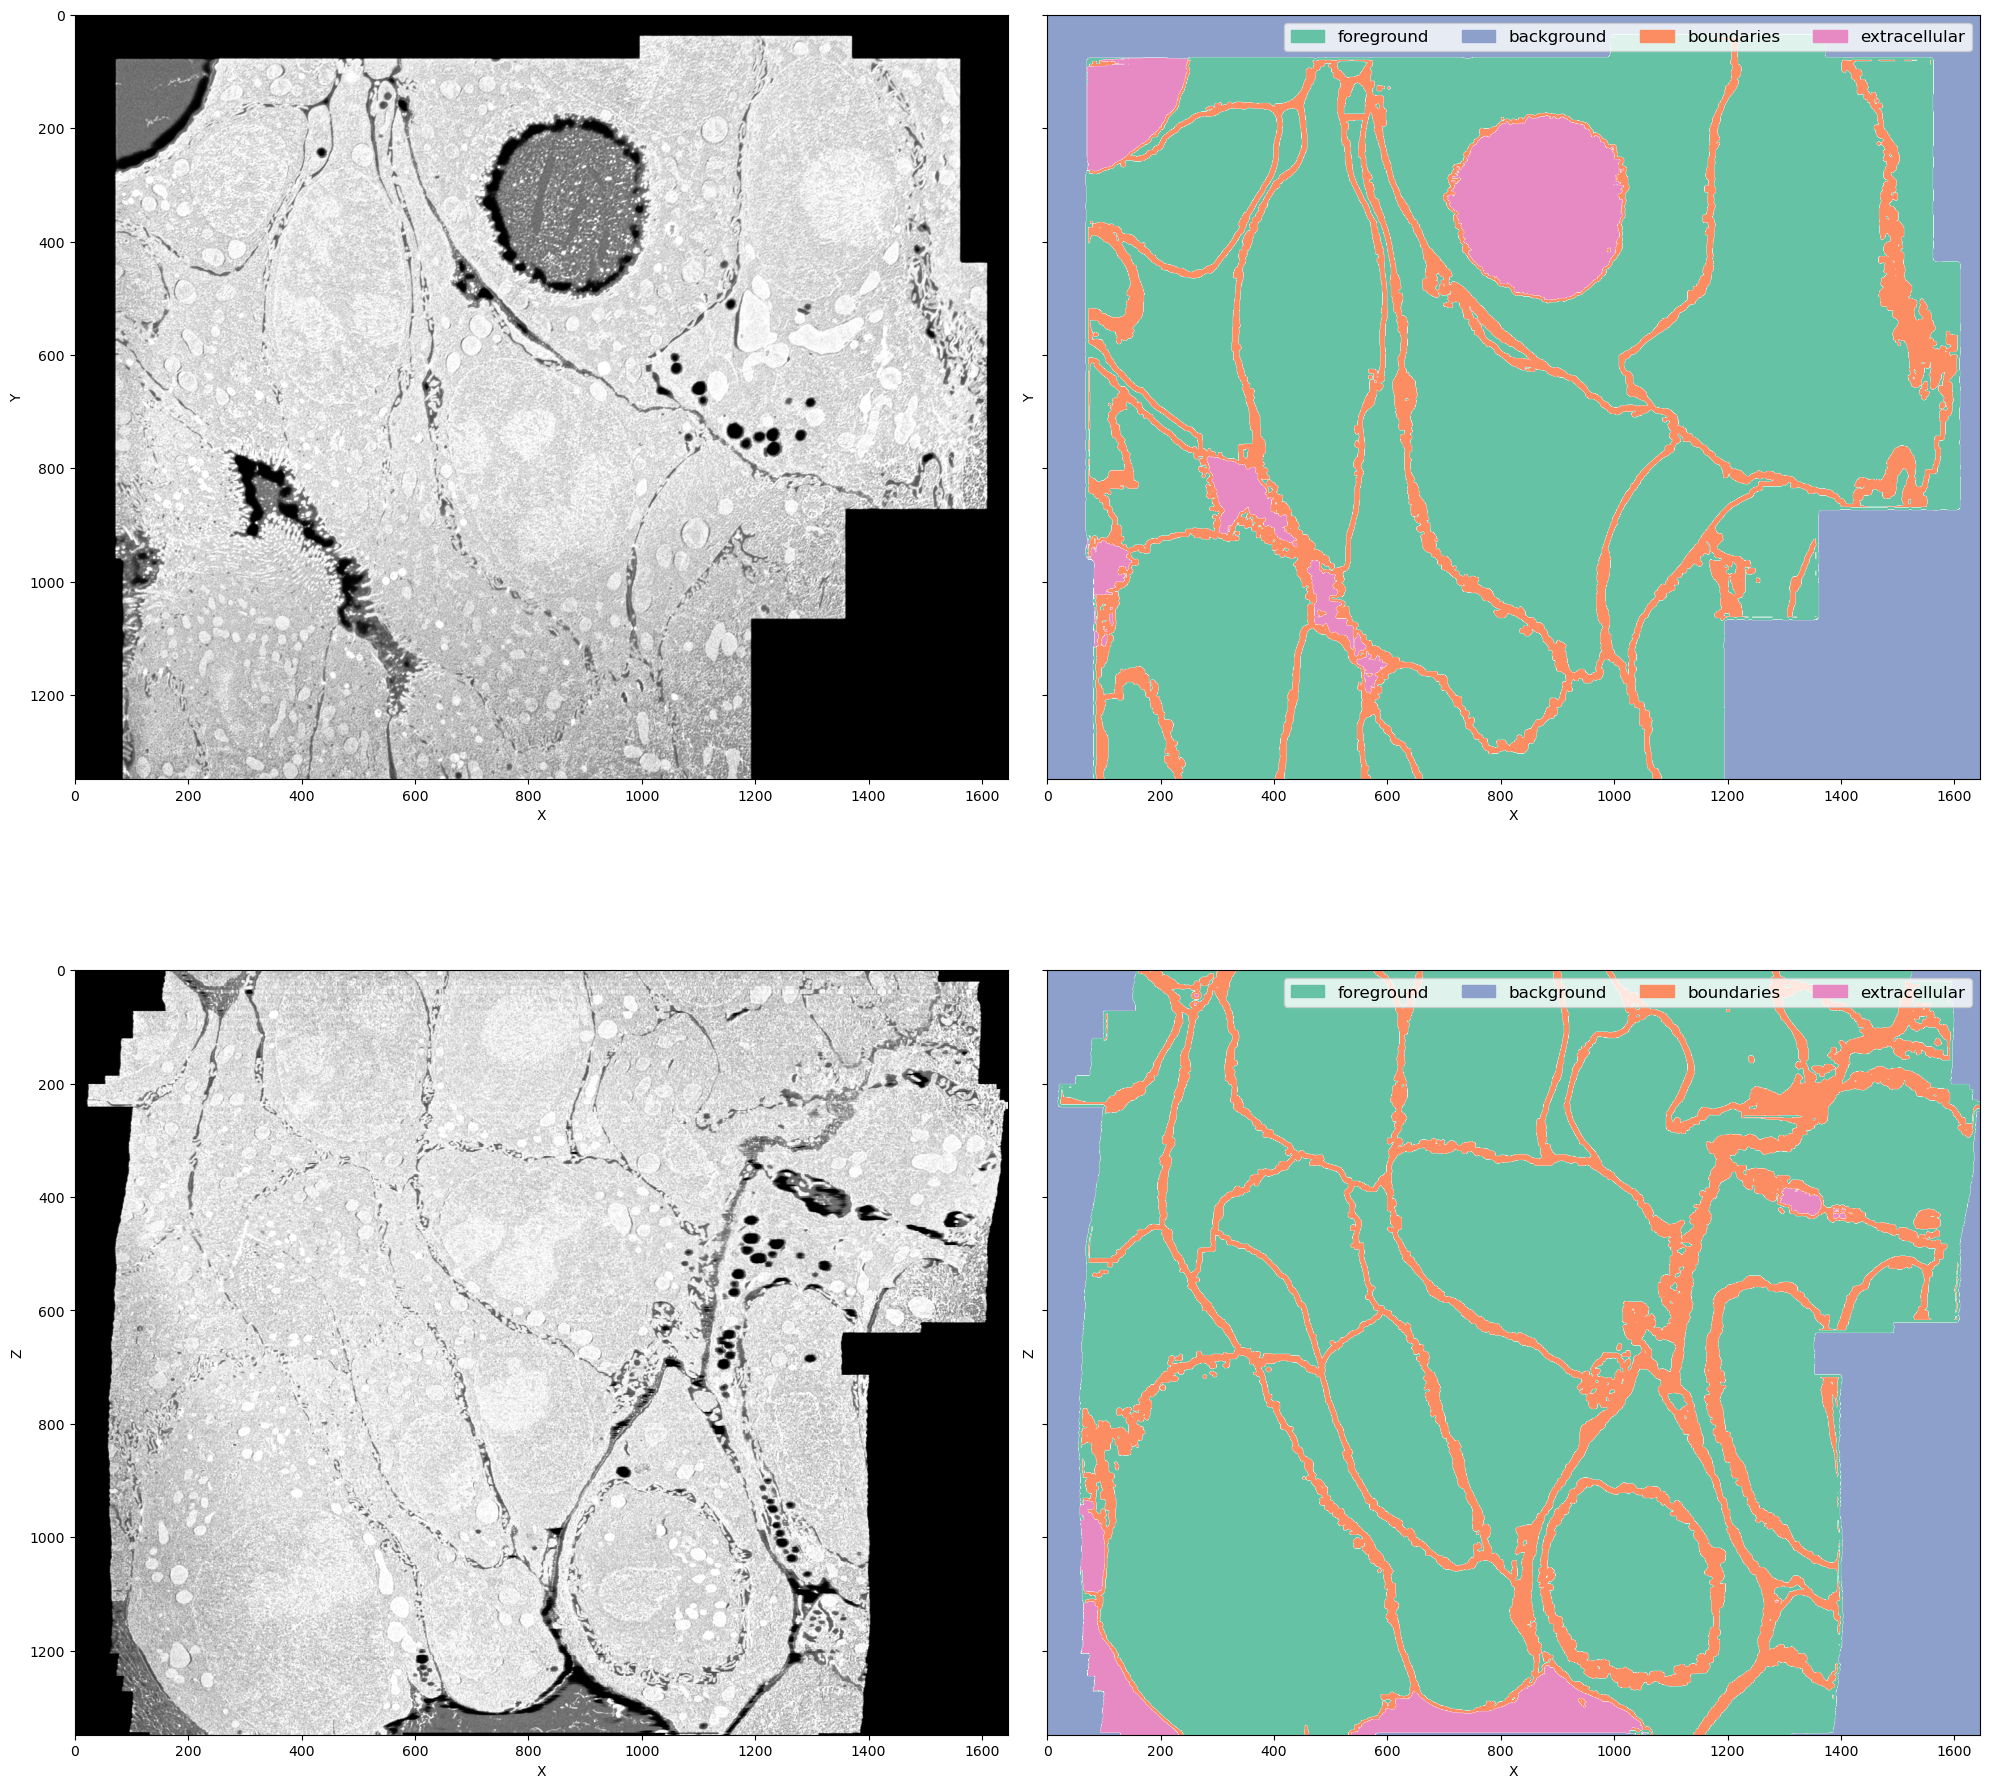

In [6]:
xy_slice_roi = np.s_[500, :, :]
xz_slice_roi = np.s_[:, 750, :]
plt.figure(figsize=(20, 20))

f, ax = plt.subplots(2, 2, sharey=True, figsize=(20, 20))

ax[0, 0].imshow(data[xy_slice_roi], cmap="Greys_r")
ax[0, 0].set_xlabel("X")
ax[0, 0].set_ylabel("Y")

ax[1, 0].imshow(data[xz_slice_roi], cmap="Greys_r")
ax[1, 0].set_xlabel("X")
ax[1, 0].set_ylabel("Z")

legend_patches = []
for name, chan in channels.items():
    cmap = colors.ListedColormap(['white', cols[name]])
    ax[0, 1].imshow(label[chan][xy_slice_roi], label=name, cmap=cmap, alpha=(label[chan][xy_slice_roi] > 0).astype(float))
    legend_patches.append(mpatches.Patch(color=cols[name], label=full_names[name]))

ax[1, 1].legend(handles=legend_patches, fontsize="large", ncol=4)
ax[0, 1].set_xlabel("X")
ax[0, 1].set_ylabel("Y")

legend_patches = []
for name, chan in channels.items():
    cmap = colors.ListedColormap(['white', cols[name]])
    ax[1, 1].imshow(label[chan][xz_slice_roi], label=name, cmap=cmap, alpha=(label[chan][xz_slice_roi] > 0).astype(float))
    legend_patches.append(mpatches.Patch(color=cols[name], label=full_names[name]))


ax[0, 1].legend(handles=legend_patches, fontsize="large", ncol=4)
ax[1, 1].set_xlabel("X")
ax[1, 1].set_ylabel("Z")


plt.tight_layout()

This is a FIB-SEM volume of a tissue and the task was to segment individual cells out. For that we need a network to perform semantic segmentation of 4 classes:

- Foreground: areas inside the cells
- Background: black area where there is no electron microscopy signal
- Boundaries: interfaces between cells
- Extracellular matrix: free space between cells

Why this dataset? It's not really a benchmark dataset and it's legit to ask why do we care about segmenting cell boundaries in some weird organoids. In my opinion it neatly demonstrates the difficulties bioimage analysts face in every project:

- The volume is large ($1349 \times 1505 \times 1646$ pixels) but not crazy large (fully fits into RAM on a decent machine but definitely not into GPU memory)
- The imaging method (FIB-SEM) is well-established but the sample preparation for this particular sample was quite special, so the visual appearance is unique
- Even if we imagine taking a model for cell boundaries trained on some other electron microscopy data (I'm not aware of the existance of any dataset that is even somewhat similar), it doesn't solve the problem of segmenting extracellular matrix
- Seems like `image == 0` should solve segmenting background class, but there are the lipid droplets which also have 0 signal. In principle we could apply an heuristic for segmenting background, like taking the largest connected component, but it is not transferable to other datasets (not shown here). One of the downstream tasks is counting lipid droplets per cell, so ignoring them is not an option as well  
- Cell boundaries can be super thin - down to 1 pixel wide - or very thick in different parts of the dataset, so it's not possible to downsample it further
- The dataset is quite unbalanced but the classes are distributed throughout the volume so it's not possible to pick just one foreground area and train on it

fg 0.564123369077732


bg 0.2950981764296163
boundaries 0.09271733890749893
extra 0.04806111558515283


Text(0, 0.5, 'Proportion of the class is full dataset')

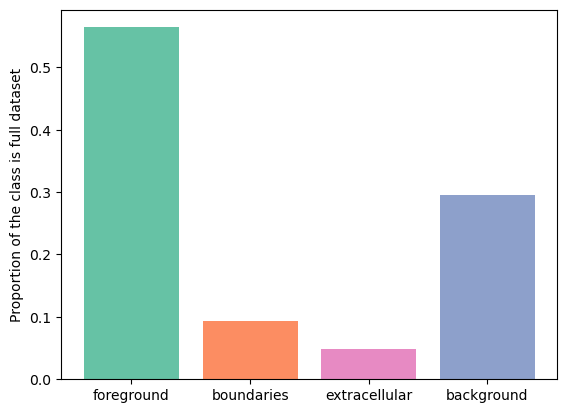

In [7]:
plt.figure()
for name, chan in channels.items():
    plt.bar(chan, label[chan].sum() / label[chan].size, tick_label=full_names[name], color=cols[name])
    print(name, label[chan].sum() / label[chan].size)
names = channels.keys()
plt.xticks([channels[name] for name in names], [full_names[name] for name in names]);
plt.ylabel("Proportion of the class is full dataset")

As we can see, boundaries class takes up $9%$ of the volume. Let's sample the training samples of size $128 \times 128 \times 128$ from the dataset and check the distribution of the boundaries class.

In [8]:
from monai.data import GridPatchDataset, DataLoader, PatchIterd
patch_iter = PatchIterd(keys=["image", "label"], patch_size=(128, 128, 128), start_pos=(0, 0, 0))
grid_dataset = GridPatchDataset(data=ds, patch_iter=patch_iter)
from tqdm import tqdm
class_distribution = {"fg": [], "boundaries": [], "extra": [], "bg": []}

for item in tqdm(DataLoader(grid_dataset, batch_size=1, num_workers=8)):
    item = item[0]
    img = item["image"].numpy()[0]
    lbl = item["label"].numpy()[0].astype(np.uint16)
    class_distribution["fg"].append(lbl[0].sum() / lbl[0].size)
    class_distribution["boundaries"].append(lbl[1].sum() / lbl[1].size)
    class_distribution["extra"].append(lbl[2].sum() / lbl[2].size)
    class_distribution["bg"].append(lbl[3].sum() / lbl[3].size)

1716it [01:03, 26.90it/s]


Text(0.5, 0, 'Proportion of boundary class in training patch')

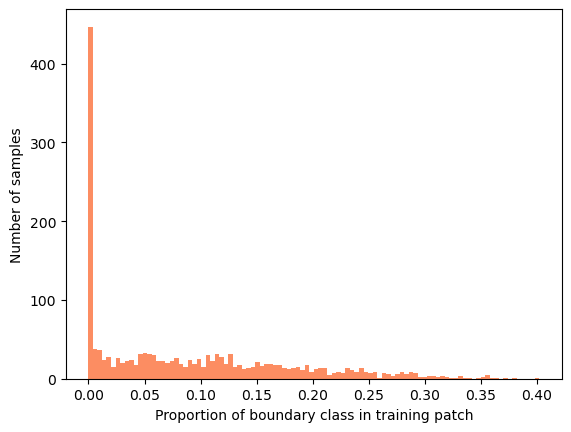

In [9]:
plt.hist(class_distribution["boundaries"], bins=100, color=cols["boundaries"])
plt.ylabel("Number of samples")
plt.xlabel("Proportion of boundary class in training patch")

Most of the samples have no boundary class and the rest of the samples are far from the dataset-wide $10%$. Sampling randomly, we would need batches of approximately N samples to correctly estimate the boundary class proportion in most samples.

In [10]:
import seaborn as sns
import pandas as pd

sampled_proportions = pd.DataFrame()
for batch_size in (1, 2, 4, 8, 16, 32, 64, 128, 256):
    sampled_proportions[batch_size] = [np.sum(np.random.choice(class_distribution["boundaries"], replace=True, size=batch_size)) / batch_size for _ in range(1000)]

Text(0, 0.5, 'Proportion of boundaries class in each batch')

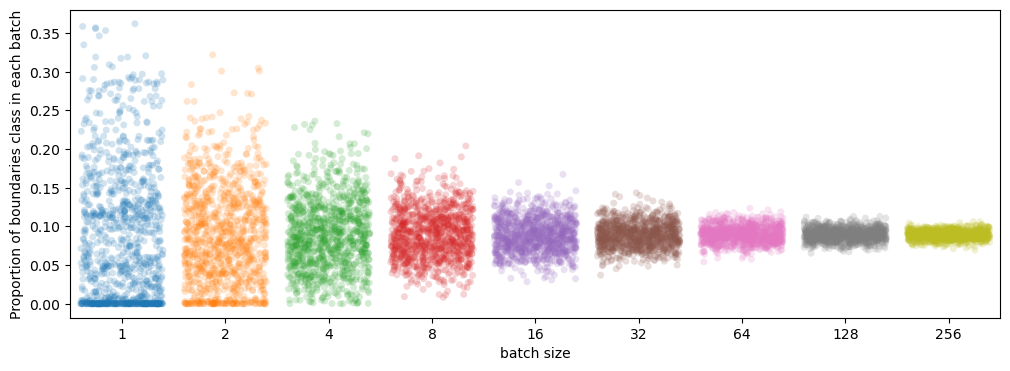

In [11]:
plt.figure(figsize=(12, 4))
sns.stripplot(sampled_proportions, jitter=0.4, alpha=0.2)
plt.xlabel("batch size")
plt.ylabel("Proportion of boundaries class in each batch")

So, to stay reasonably close to volume-wise $9%$ we would need a batch size of $32$ or more, which is impossible with current GPU memory. Of course, there can be variation within the samples of one class too but this little experiment gives us an idea of how diverse the data is and how bad we are at sampling it.  

## `BatchNorm` refresher



Neural networks consist of a series of filters with normalization and nonlinearity layers in between. Feature normalization helps to make convergence faster and more stable with respect to training parameters. In most cases it's probably possible to train a network with no normalization layers at all - however, the search for optimal learning rate schedule and other parameters might require much more effort.

 The general formula for the normalization operation with input $x$, output $y$ is:

$$
y = \frac{x-\mu}{\sqrt{\sigma^2 + \epsilon}},
$$
where $\mu$ and $\sigma$ are normalization parameters and $\epsilon$ is a small constant used for numerical stability. Parameters $\mu$ and $\sigma$ can be estimated directly from the input $\mu = \mathrm{E}[x]$ and $\sigma^2 = \mathrm{Var}[x]$, where average can be taken either over each sample independently or over the whole batch. Alternatively, global normalization parameters independent of the current input can be used. A common strategy is to estimate the parameters as a running average over multiple samples: $p_{new} = (1 - momentum) \times p_{old} + momentum \times p_{t}$. The update speed is determined by the $momentum$, set to $0.1$ by default. 

During training $BatchNorm$ uses statistics of the current batch and collects a running average. During inference it uses saved running average. Although running mean and variance are not learned in a sense that there's no gradient descent with respect to these parameters, they are estimated from the training data.

An important assumption here is that the **feature statistics of training batches remain stable and correspond to dataset-wide statistics**. Let's look at what happens when it's not the case.

## Real mean and variance of features vs batch statistics

I trained a 3D U-Net to segment the electron microscopy volume introduced earlier. This model uses $BatchNorm$:

In [12]:
from monai.utils import set_determinism
from monai.data import DataLoader, PatchDataset
from monai.transforms import RandSpatialCropSamplesd

import torch
from no_tiling.models import load_model

from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor


In [13]:
model_path = "data/experiments/organoids_boundaries/setup_01/model_epoch_0025.pth"

# Monai settings
set_determinism(seed=0)

# Set device
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device(6)
else:
    print("GPU is not available")
    device = torch.device("cpu")

# Load model    
model = load_model(model_path).to(device)
model.eval()
print(model)

GPU is available


BasicUNet features: (32, 64, 128, 32).
Scaling factors: [[2, 2, 2], [2, 2, 2]]
UNet(
  (conv_0): TwoConv(
    (conv_0): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(32, eps=1e-05, momentum=0.01, affine=False, track_running_stats=True)
        (D): Dropout3d(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (conv_1): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(32, eps=1e-05, momentum=0.01, affine=False, track_running_stats=True)
        (D): Dropout3d(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
  )
  (downs): ModuleList(
    (0): Down(
      (max_pooling): MaxPool3d(kernel_size=[2, 2, 2], stride=[2, 2, 2], padding=0, dilation=1, ceil_mode=False)
      (convs): TwoConv(
        (conv_0): Con

The network starts with the convolution `conv_0` followed by a normalization layer and nonlinearity. In principle normalization layers are supposed to standardize the features: center the distribution around zero and force unit variance. But does it actually happen when the batch size is small?

Let's extract the outputs of the very first convolution and look at their statistics.

In [14]:
nodes, _ = get_graph_node_names(model)
print(nodes)

feature_extractor = create_feature_extractor(model, return_nodes=['conv_0.conv_0.conv'])


['x', 'conv_0.conv_0.conv', 'conv_0.conv_0.adn.N', 'conv_0.conv_0.adn.D', 'conv_0.conv_0.adn.A', 'conv_0.conv_1.conv', 'conv_0.conv_1.adn.N', 'conv_0.conv_1.adn.D', 'conv_0.conv_1.adn.A', 'downs.0.max_pooling', 'downs.0.convs.conv_0.conv', 'downs.0.convs.conv_0.adn.N', 'downs.0.convs.conv_0.adn.D', 'downs.0.convs.conv_0.adn.A', 'downs.0.convs.conv_1.conv', 'downs.0.convs.conv_1.adn.N', 'downs.0.convs.conv_1.adn.D', 'downs.0.convs.conv_1.adn.A', 'downs.1.max_pooling', 'downs.1.convs.conv_0.conv', 'downs.1.convs.conv_0.adn.N', 'downs.1.convs.conv_0.adn.D', 'downs.1.convs.conv_0.adn.A', 'downs.1.convs.conv_1.conv', 'downs.1.convs.conv_1.adn.N', 'downs.1.convs.conv_1.adn.D', 'downs.1.convs.conv_1.adn.A', 'upcats.0.upsample.deconv', 'upcats.0.convs.conv_0.conv', 'upcats.0.convs.conv_0.adn.N', 'upcats.0.convs.conv_0.adn.D', 'upcats.0.convs.conv_0.adn.A', 'upcats.0.convs.conv_1.conv', 'upcats.0.convs.conv_1.adn.N', 'upcats.0.convs.conv_1.adn.D', 'upcats.0.convs.conv_1.adn.A', 'upcats.1.upsamp

In [15]:
running_mean = model.conv_0.conv_0.adn.N.running_mean.cpu().numpy()
running_var = model.conv_0.conv_0.adn.N.running_var.cpu().numpy()

In [16]:
n_samples = 100

train_sampler = RandSpatialCropSamplesd(keys=["image", "label"], roi_size=[128, 128, 128], num_samples=n_samples,
                            random_center=True, random_size=False)

train_patch_dataset = PatchDataset(data=ds,
            patch_func=train_sampler,
            samples_per_image=n_samples)

train_loader = DataLoader(train_patch_dataset, batch_size=1)

In [17]:
feature_extractor = create_feature_extractor(
model, return_nodes=['conv_0.conv_0.conv'])

conv_features = []

for tile in train_loader:
    # Plot input
    # print(tile["image"])
    # plt.imshow(tile["image"][0, 0, 32, ...])
    plt.show()
    out = feature_extractor(tile["image"].to(device))
    conv_feat = out['conv_0.conv_0.conv'].detach().to("cpu")
    # Plot feature maps
    # plt.imshow(conv_feat[0, 8, 32, ...])
    # plt.show()
    conv_features.append(conv_feat[0, :, ...])

tile_mean = np.array([np.mean(feat, axis=(1, 2, 3)) for feat in conv_features])
tile_var = np.array([np.var(feat, axis=(1, 2, 3)) for feat in conv_features])

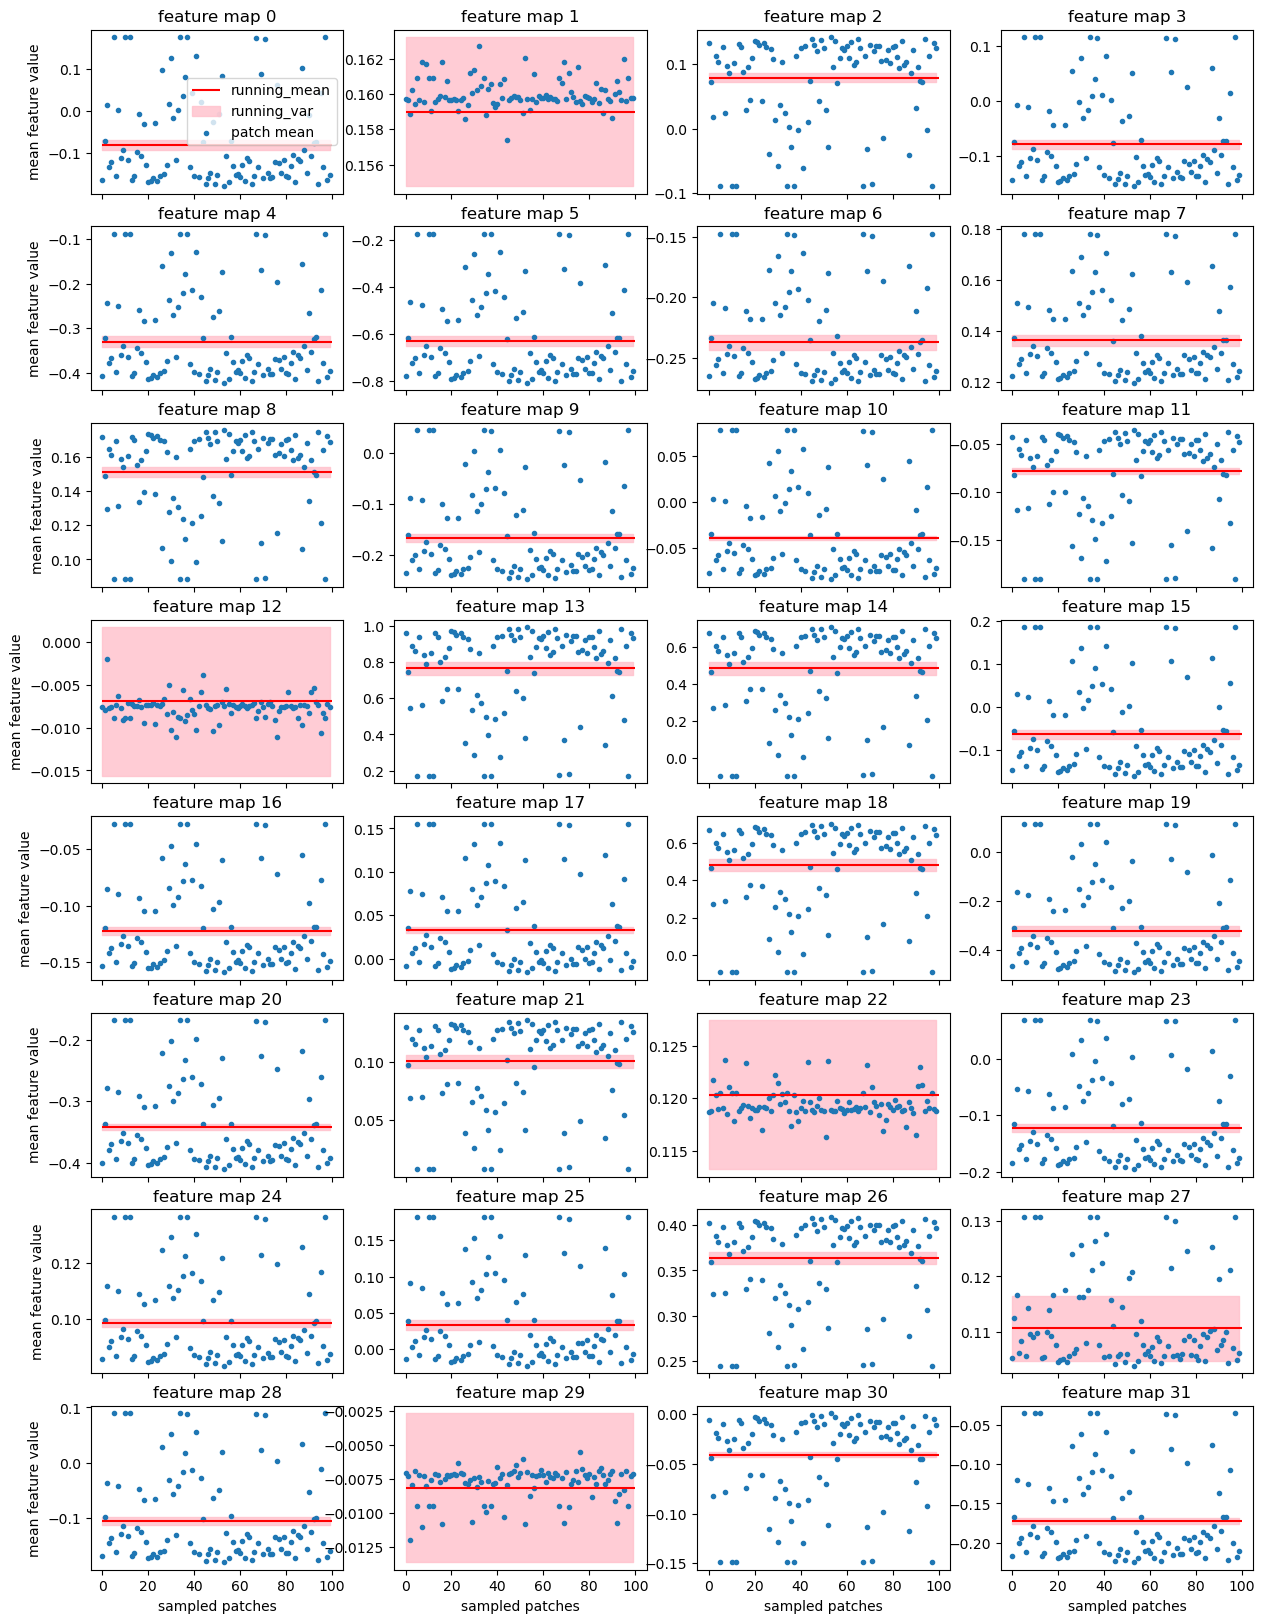

In [18]:
f, axes = plt.subplots(8, 4,  sharex=True, figsize=(15, 20))

for feat_idx, ax in enumerate(axes.flat):
    
    ax.hlines(running_mean[feat_idx], xmin=0, xmax=n_samples, color="red", label="running_mean")
    # plt.hlines(tile_mean[:, 0].mean(), xmin=0, xmax=100, color="green")
    ax.fill_between(range(n_samples), [running_mean[feat_idx] + running_var[feat_idx]] * n_samples,  [running_mean[feat_idx] - running_var[feat_idx]] * n_samples, color="pink", alpha=0.8, label="running_var")
    ax.scatter(range(n_samples), tile_mean[:, feat_idx], marker=".", label="patch mean")
    
    ax.set_title(f"feature map {feat_idx}")

axes[0, 0].legend()
for idx in range(4):
    axes[7, idx].set_xlabel("sampled patches")
for idx in range(8):
    axes[idx, 0].set_ylabel("mean feature value")


plt.show()

Here each of the 32 small panels corresponds to one feature map of the very first convolution layer. This convolution is applied directly to the input data and its output does not depend on the normalizations within the network. We just run the network on 100 random patches from the training subvolume using exactly the same data loader as was used while training the model. 

- Each blue dot is a mean of the particular feature over one patch - this value is used by `BatchNorm` for normalization during training
- Red line is the `running_mean` remembered by `BatchNorm` during training - this value is used for normalization during inference
- Pink area is `running_var` remembered by `BatchNorm` during training

With batch size 1 during training each patch gets nicely standardized because `BatchNorm` uses statistics of the input. During evaluation `running_mean` and `running_var` are used - and they are just wrong for most of the patches! 

But maybe it's not that bad? Let's check how this affects the predictions.

## Train/eval disparity

Usually people assume that the network performs roughly the same in `train` and `eval` mode. But we have just seen that the feature maps are normalized completely differently. Let's try to run the network on the same patch in train and eval mode and see if there's a difference.

In [19]:
n_samples = 5

train_sampler = RandSpatialCropSamplesd(keys=["image", "label"], roi_size=[128, 128, 128], num_samples=n_samples,
                            random_center=True, random_size=False)

train_patch_dataset = PatchDataset(data=ds,
            patch_func=train_sampler,
            samples_per_image=n_samples)

train_loader = DataLoader(train_patch_dataset, batch_size=1)

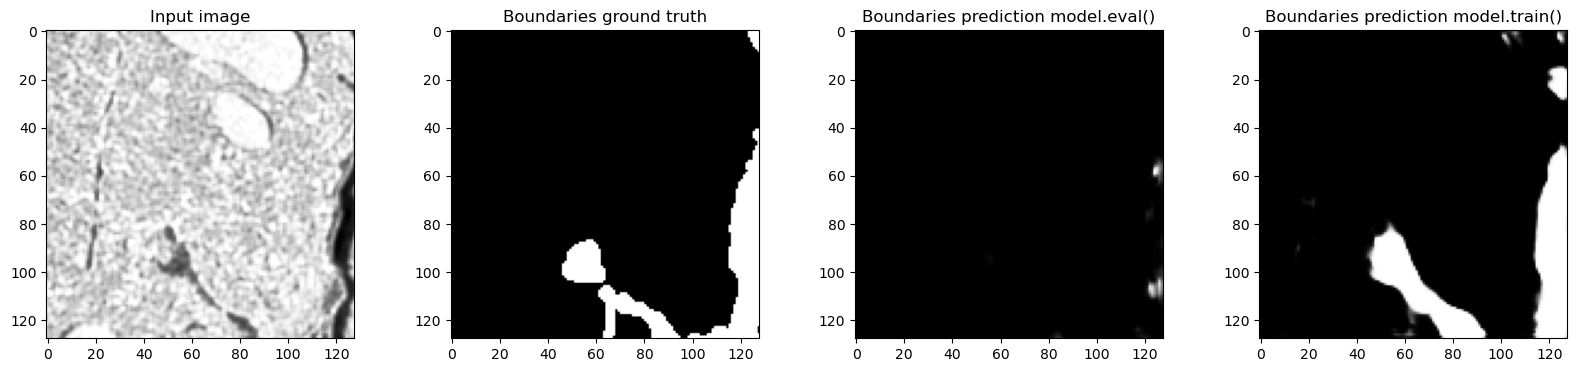

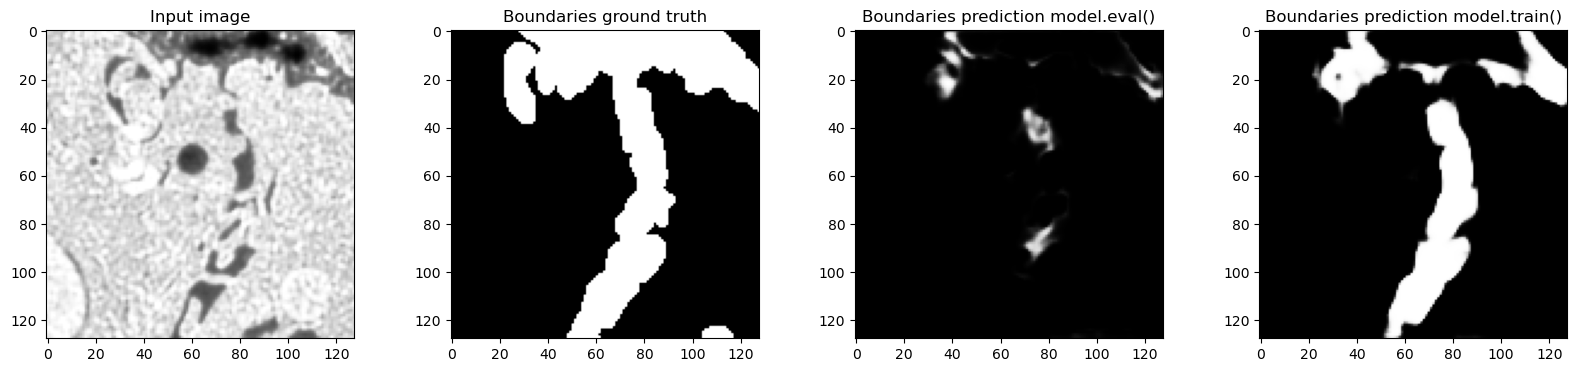

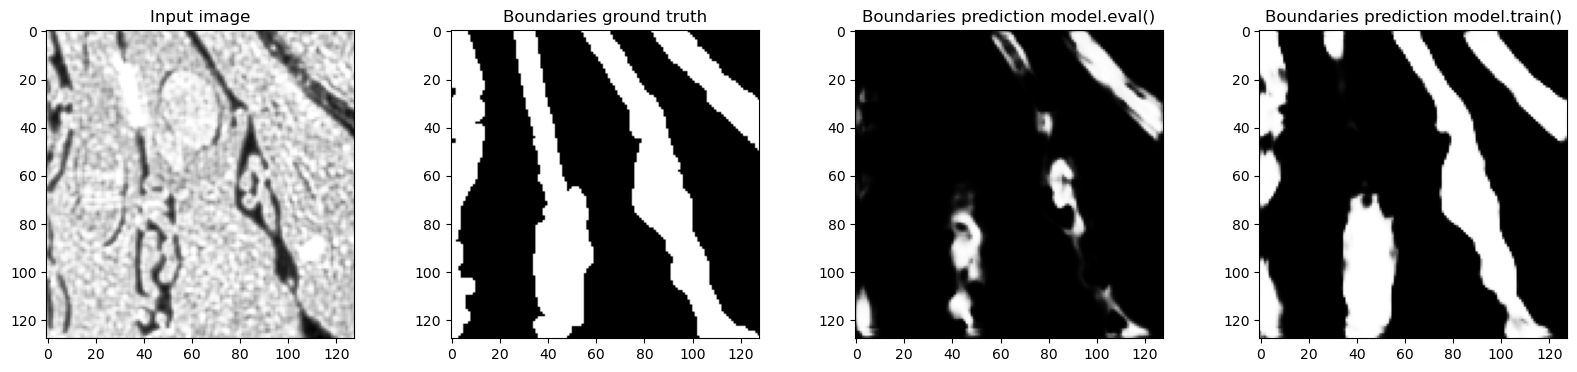

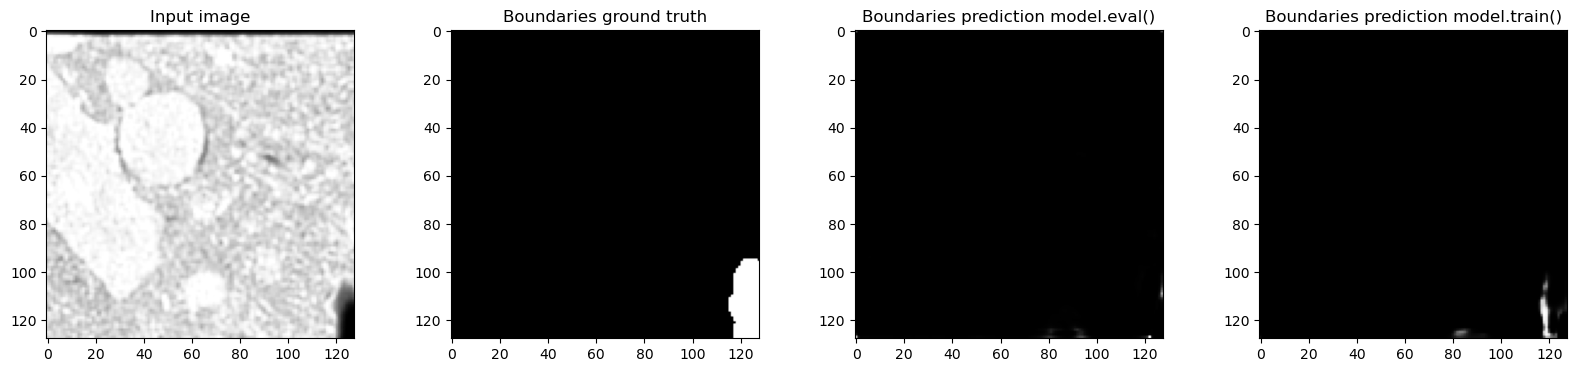

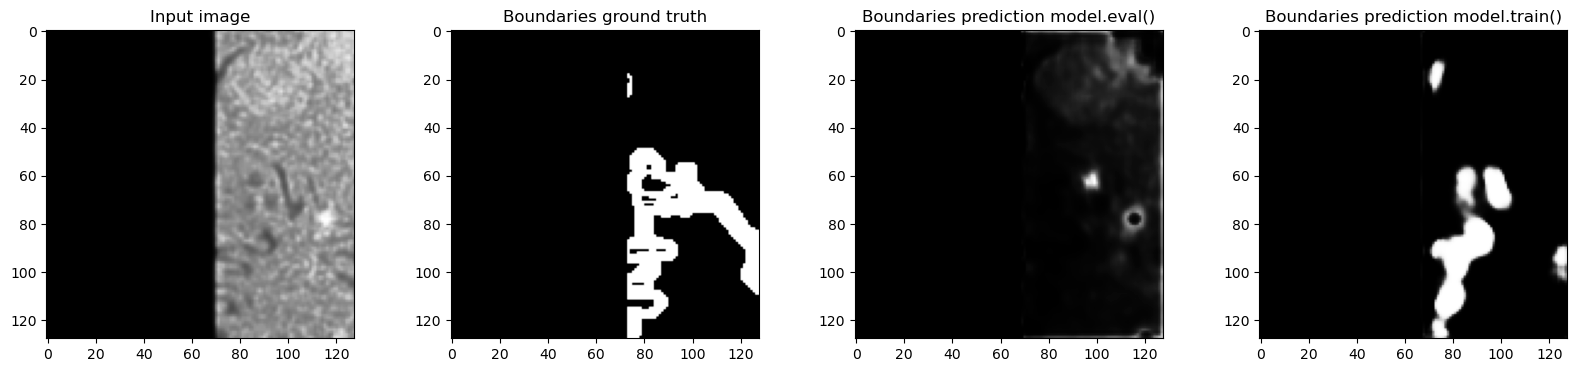

In [20]:
for tile in train_loader:

    # Only show examples with boundary class in the ground truth
    if tile["label"][0, 1, 32, ...].sum() > 0:

        f, axes = plt.subplots(1, 4,  sharex=True, figsize=(20, 4))

        axes[0].imshow(tile["image"][0, 0, 32, ...], cmap="Greys_r")
        axes[0].set_title("Input image")
        axes[1].imshow(tile["label"][0, 1, 32, ...], cmap="Greys_r")
        axes[1].set_title("Boundaries ground truth")

        model.eval()
        out_eval = model(tile["image"].to(device)).detach().to("cpu")

        axes[2].imshow(out_eval[0, 1, 32, ...], cmap="Greys_r")
        axes[2].set_title("Boundaries prediction model.eval()")

        model.train()
        out_train = model(tile["image"].to(device)).detach().to("cpu")

        axes[3].imshow(out_train[0, 1, 32, ...], cmap="Greys_r")
        axes[3].set_title("Boundaries prediction model.train()")

        plt.show()

Predictions in `train` and `eval` modes are actually very different and the predictions in training mode are much closer to the ground truth - which makes sense, because the network was trained with normalization layers always using the statistics of the input batch. In this case `batch_size=1` so the plots where we looked at the real feature mean and remembered value accurately show what happened. 

The training looked all normal with both train and eval loss going down. There was a gap between train and eval metric (Mean Dice 0.75 for train and 0.65 for eval) but it could in theory result from the overfitting. 

## Train/eval disparity metric

Of course, the difference is random patch to patch so it's better to run sliding window inference for the full dataset in both modes and compare the results. 

To measure the difference quantitatively, I introduced the following metric: 
$$
train/eval\ disparity = 1 - Dice(P_{train}, P_{eval}), 
$$ 
where $P_{train}$ is the prediction done with  `model.train()` and $P_{eval}$ - with `model.eval()`. If the predictions match perfectly, mismatch is 0 and if they are the exact opposites of each other, it's 1.

For our example dataset, train/eval mismatch for the boundary channel is 0.48, which is actually surprisingly strong difference. At this point the loss calculated during training is basically not representative of the real model performance all due to batch statistics instability. 

## Practical tips

### How to check if statistics instability ruins my network's performance?

- Run your prediction pipeline with `model.eval()` and `model.train()` **on the same data** and compare the results 
- Compare results visually or quantify using train/eval disparity metric
- The difference can be larger or smaller in different parts of the dataset. For the best evaluation try to either run prediction in both modes on the whole evaluation dataset or at least make sure to get a representative sampling
- This notebook shows the results for semantic segmentation but the same applies to other tasks. For example, for classification Dice in the train/eval disparity metric can be replaced with accuracy, F1 score or your favorite metric

### I have train/eval mismatch - what to do?

If you established that the model performance degrades when you switch from `model.train()` to `model.eval()`, unfortunately, there's not much to do but to retrain the model. This problem appears because the training batches were too random and not representative of the overall dataset distribution.   

If you are willing to retrain, there are multiple options:


- Use larger batch size

    As we have seen in our experiment with different batch sizes, the larger the batch size, the more likely it is that the samples correctly represent the diversity of the dataset. Chances are you are already using the largest possible batch size but hey this is a great reason to get a cooler GPU.

- Downsample the data

    Old image analysis wisdom says: solve your problem at the minimal possible resolution. Downsampling the image makes effective patch size larger, meaning that the same amount of GPU memory can be used to sample more of the dataset. In my experience, downsampling microscopy data is rarely viable because the objects of interest (cell or nuclei boundaries, organelles, membranes) are already at the edge of what is possible to recognize at the available resolution. 

- Sample only foreground patches or control the proportion of classes in a batch for classification

    Sampling only patches that contain foreground is an easy way to reduce variability of the patches and make patch feature distributions more stable. In tasks such as nuclei segmentation in light microscopy (bright objects on mostly dark background), this approach works perfectly. Of course, for electron microscopy it would not work: if I were to sample only the cell boundaries, there would be no patches coming from middle part of the cells. There are many features inside the cell that resemble the boundary, so if they were not present in the training patches, who knows what the network would predict there.

    I looked into a lot of publications which use U-Net for segmentation of microscopy or medical images and most of them had some kind of weighted patch sampling. I believe that it was a secret for making their training work (as opposed to whatever was claimed in the paper, such as a fancy loss or specialized augmentation). In the remaining cases it could be that the training data was cropped to contain only the region of interest in the first place.

- `BatchRenorm`
    
    If none of the above are possible, I suggest giving `Batch Renormalization` a try. `BatchRenorm` is a normalization layer that uses running mean and variance both during training and during inference. I managed to achieve quite good results with it both for electron and fluorescent microscopy images However, the training takes a bit longer.

### Adding more ground truth doesn't solve the problem

The usual explanation of the mismatch between `train` and `eval` mode is overfitting. In principle overfitting could be partially solved with adding more ground truth by achieving more representative training sample. Batch statistics instability prevents the network from effectively using the training data, so **even performance on the training set is suboptimal**. Wrong estimation of mean and variance of the feature maps prevents the network from making good predictions in eval mode even for the data from the training set. 

## Conclusion

- Biological images often have high variability within one image and are much larger than GPU memory. Patches sampled in training can have completely different class distribution and even completely miss some classes due to general class imbalance and image content distribution.

- Especially for 3D data the batch size is very limited by the GPU memory. It is pretty normal to use batch size 1 or 2. Together with high diversity within images this causes batch statistics of feature maps to be estimated incorrectly. Running mean and variance do not correspond to the training mode batch statistics, leading to a puzzling low prediction quality when the model is applied to the new data. 

- Of course, this tutorial shows an extreme case. The strength of the effect depends on the interplay between the data homogeneity, sampling strategy, patch size and batch size. Due to this a training pipeline that worked perfectly fine on one dataset can completely fail on another similar dataset - and it's really hard to say why unless we keep the normalization in mind. 

Let's say we want to segment mitochondria in different datasets. In one case in the training image, mitochondria happened to be evenly distributed throughout the cell for biological reasons - then the batch statistics will be rather stable because it's likely that each patch hits an area with some mitochondria. In the other case large areas of the cell don't have mitochondria - the batch statistics might be way less stable and the model might perform much worse. It's very hard to debug because the images might seem similar in terms of resolution or contrast, why would the same training pipeline not work for both? 

- Fortunately, it's very easy to check if train/eval disparity is a problem in a particular case. Just check if predictions in both modes on the same image are close enough. If there is a significant difference but you are not convinced, it's possible to check the feature maps and see directly if statistics are different.

For examples of different modalities, architectures (Transformer-based networks suffer from this too!) and quantitative results check out my manuscript [Tiling artifacts and trade-offs of feature normalization in the segmentation of large biological images](https://arxiv.org/abs/2503.19545).